# Beginning

In [61]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import tree as tr
from sklearn.neural_network import MLPClassifier
from generalized_mlm import MixtureLinearModel

from rpy2 import robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import default_converter
from rpy2.robjects.conversion import localconverter
# Load Rforestry package
r('if (!requireNamespace("devtools", quietly = TRUE)) install.packages("devtools")')
r('library(devtools)')
r('devtools::load_all("../Rforestry")')
forestry = importr("Rforestry")


ℹ Loading Rforestry
! Adding files missing in collate:
  '/Users/evgeniikuriabov/PycharmProjects/JCGS_review/Rforestry/R/leafCoefficients.R'


R callback write-console: ## 
##  Rforestry (Version 0.10.1, Build Date: )
##  See https://github.com/forestry-labs for additional documentation.
##  Please cite software as:
##    Soren R. Kunzel, Theo F. Saarinen, Edward W. Liu, Jasjeet S. Sekhon. 2019.
##    ''Linear Aggregation in Tree-based Estimators.'' arXiv preprint 
##    arXiv:1906.06463. https://arxiv.org/abs/1906.06463 
##
  


In [62]:
import warnings
warnings.filterwarnings("ignore")

In [63]:
class _ForestryMixin(BaseEstimator):
    _ntree: int = 1

    def __init__(self):
        self.model_ = None

    def fit(self, X, y):
        with localconverter(default_converter + pandas2ri.converter):
            ro.globalenv["X"] = pd.DataFrame(X)
            ro.globalenv["y"] = pd.Series(y)
        ro.r(f"model <- forestry(x = X, y = y, ntree = {self._ntree})")
        self.model_ = ro.globalenv["model"]
        return self

    def _predict_r(self, newX):
        with localconverter(default_converter + pandas2ri.converter):
            ro.globalenv["X_new"] = pd.DataFrame(newX)
        preds = ro.r("predict(model, newdata = X_new, feature.new = X_new)")
        return np.asarray(preds, dtype=float)

class LRTClassifier(_ForestryMixin, ClassifierMixin):
    _ntree = 1
    def predict_proba(self, X):
        p = self._predict_r(X)
        return np.column_stack([1 - p, p])
    def predict(self, X):
        return (self._predict_r(X) > 0.5).astype(int)

class LRTRegressor(_ForestryMixin, RegressorMixin):
    _ntree = 1
    def predict(self, X):
        return self._predict_r(X)
    
class LRFClassifier:
    """Light wrapper around Rforestry with adjustable ntree."""
    def __init__(self, ntree=500):
        self._ntree = ntree
        self.model_ = None

    def fit(self, X, y):
        # push into R
        with localconverter(default_converter + pandas2ri.converter):
            ro.globalenv["X"] = pd.DataFrame(X)
            ro.globalenv["y"] = pd.Series(y)
        # call forestry()
        ro.r(f"model <- forestry(x = X, y = y, ntree = {self._ntree})")
        self.model_ = ro.globalenv["model"]
        return self

    def predict(self, X):
        # push new data
        with localconverter(default_converter + pandas2ri.converter):
            ro.globalenv["X_new"] = pd.DataFrame(X)
        preds = ro.r("predict(model, newdata = X_new, feature.new = X_new)")
        # threshold at 0.5
        return (np.asarray(preds, dtype=float) > 0.5).astype(int)
    
class LRFRegressor(LRTRegressor): _ntree = 500

In [64]:
path = './data/'
df = pd.read_csv(path + "TCGA_skcm.csv")

data = df.iloc[:,1:]
orig_headers = list(data)
outcome_header = "OS_STATUS"

feature_names = list(data)
feature_names.remove(outcome_header)

one_vars = np.where(np.array([len(np.unique(x)) for x in np.array(data).T])==1)[0]
for i in [orig_headers[i] for i in one_vars]:
    feature_names.remove(i)
    
Xo = data[feature_names].values
y = data[outcome_header].values


cate_vars = np.where((np.array([len(np.unique(x)) for x in np.array(Xo).T])<=12) &
                    (np.array([len(np.unique(x)) for x in np.array(Xo).T])>2))[0]
cont_vars = np.where((np.array([len(np.unique(x)) for x in np.array(Xo).T])>12) |
                    (np.array([len(np.unique(x)) for x in np.array(Xo).T])<=2))[0]
cate_vars = np.setdiff1d(cate_vars,[10])
cate_vars = np.sort(np.append(cate_vars,27))
cont_vars = np.setdiff1d(cont_vars,[27])
cont_vars = np.sort(np.append(cont_vars,10))

X_cate = Xo[:,cate_vars]
X_cont = Xo[:,cont_vars]
names_cont = [feature_names[i] for i in cont_vars]
names_cate = [feature_names[i] for i in cate_vars] 


X_cont_min, X_cont_max = X_cont.min(axis=0), X_cont.max(axis=0)
X_cont = (X_cont-X_cont_min)/(X_cont_max - X_cont_min + 1e-9)
    
df_cate = [pd.get_dummies(Xo[:,i], drop_first=True).values for i in cate_vars]
X_cate = np.hstack(df_cate)
a = sum([list(np.repeat(names_cate[i],j)) for i,j in enumerate([x.shape[1] for x in df_cate])],[])
b = sum([list(range(i)) for i in [x.shape[1] for x in df_cate]],[])
names_cate = ['{}{}'.format(a[i],b[i]) for i in range(len(b))]     
    
X = np.hstack([X_cont,X_cate])
feature_names = sum([names_cont,names_cate],[]) 


print(X.shape, y.shape, len(feature_names))
list(zip(feature_names,[len(np.unique(X[:,i])) for i in range(X.shape[1])]))

(388, 73) (388,) 73


[('AGE', 69),
 ('DAYS_TO_COLLECTION', 357),
 ('ETHNICITY', 2),
 ('FORM_COMPLETION_DATE', 104),
 ('FRACTION_GENOME_ALTERED', 372),
 ('HISTORY_NEOADJUVANT_TRTYN', 2),
 ('HISTORY_OTHER_MALIGNANCY', 2),
 ('ICD_10', 39),
 ('ICD_O_3_HISTOLOGY', 10),
 ('ICD_O_3_SITE', 35),
 ('INITIAL_PATHOLOGIC_DX_YEAR', 31),
 ('NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT', 2),
 ('OCT_EMBEDDED', 2),
 ('OS_MONTHS', 368),
 ('PRIMARY_MELANOMA_KNOWN_DX', 2),
 ('PROSPECTIVE_COLLECTION', 2),
 ('RADIATION_TREATMENT_ADJUVANT', 2),
 ('RETROSPECTIVE_COLLECTION', 2),
 ('SAMPLE_COUNT', 2),
 ('SAMPLE_INITIAL_WEIGHT', 76),
 ('SAMPLE_TYPE', 2),
 ('SAMPLE_TYPE_ID', 2),
 ('SEX', 2),
 ('SUBMITTED_TUMOR_DX_DAYS_TO', 260),
 ('VIAL_NUMBER', 2),
 ('AJCC_NODES_PATHOLOGIC_PN0', 2),
 ('AJCC_NODES_PATHOLOGIC_PN1', 2),
 ('AJCC_NODES_PATHOLOGIC_PN2', 2),
 ('AJCC_NODES_PATHOLOGIC_PN3', 2),
 ('AJCC_NODES_PATHOLOGIC_PN4', 2),
 ('AJCC_NODES_PATHOLOGIC_PN5', 2),
 ('AJCC_NODES_PATHOLOGIC_PN6', 2),
 ('AJCC_NODES_PATHOLOGIC_PN7', 2),
 ('AJCC_NODES_

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [66]:
clf_1 = RandomForestClassifier()
clf_1.fit(X_train, y_train)
print('auc train:', roc_auc_score(clf_1.predict(X_train), y_train))
print('auc test:', roc_auc_score(clf_1.predict(X_test), y_test))

auc train: 1.0
auc test: 0.8048128342245988


In [67]:
clf_2 = GradientBoostingClassifier()
clf_2.fit(X_train, y_train)
print('auc train:', roc_auc_score(clf_2.predict(X_train), y_train))
print('auc test:', roc_auc_score(clf_2.predict(X_test), y_test))

auc train: 0.9808662303555796
auc test: 0.7996031746031746


In [68]:
clf_3 = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(15, 2), random_state=1)
clf_3.fit(X_train, y_train)
print('auc train:', roc_auc_score(clf_3.predict(X_train), y_train))
print('auc test:', roc_auc_score(clf_3.predict(X_test), y_test))

auc train: 0.9542857142857143
auc test: 0.7631229235880399


In [69]:
clf_4 = LRFClassifier()
clf_4.fit(X_train, y_train)

forest_preds_train = clf_4.predict(X_train)
forest_preds = clf_4.predict(X_test)

print("Train", roc_auc_score(y_train, forest_preds_train))
print("Test", roc_auc_score(y_test, forest_preds))

Train 1.0
Test 0.7757936507936508


In [70]:
m1 = tr.DecisionTreeClassifier()
m1.fit(X_train, y_train)
m1_pred = m1.predict(X_train)
m1_pred_test = m1.predict(X_test)
print("Train DT:", roc_auc_score(m1_pred, y_train))
print("Test DT:", roc_auc_score(m1_pred_test, y_test), "depth", m1.get_depth())

m = LogisticRegression()
m.fit(X_train, y_train)
m_pred = m.predict(X_train)
m_pred_test = m.predict(X_test)
print("Train:", roc_auc_score(m_pred, y_train))
print("Test:", roc_auc_score(m_pred_test, y_test))

Train DT: 1.0
Test DT: 0.7051282051282052 depth 12
Train: 0.8172786720321932
Test: 0.7960526315789473


In [71]:
#Number of leaves in CART
m1.get_n_leaves()

48

In [72]:
fr = LRTClassifier()
fr.fit(X_train, y_train)

forest_preds_train = fr.predict(X_train)
forest_preds = fr.predict(X_test)

print("Train", roc_auc_score(y_train, forest_preds_train))
print("Test", roc_auc_score(y_test, forest_preds))

Train 0.8581365321337832
Test 0.6071428571428572


# MLM Method

In [86]:
#Models to use for co-supervision
clfs = [clf_1, clf_2, clf_3]

sorted_clf = []
for i in clfs:
    sorted_clf.append((i, roc_auc_score(np.round(i.predict(X_test)), y_test)))
sorted_clf = sorted(sorted_clf, key=lambda x: x[1])

In [87]:
avg_variance = np.mean(np.var(X_train, axis=0))

In [88]:
MLM = MixtureLinearModel(sorted_clf, verbose=True)

In [89]:
MLM.compute_kmeans_CELL(X_train, K=13, random_seed=0)

73 (73,)
# of CELL:13 / min size:7 / avg size:23.8 / max size:48 / # of singleton CELL:0


In [90]:
MLM.fit_LocalModels(X_train, y_train, 
                    eps=avg_variance, num_noise_samp=100, 
                    classification=True, alpha=0, max_iter=10000, random_seed=0, verbose=False)

In [91]:
pred_lmm_train = MLM.predict(X_train, covariance_tied=False, uniform_prior=False)
pred_lmm_test = MLM.predict(X_test, covariance_tied=False, uniform_prior=False)

In [92]:
print('MLM-CELL: Train AUC:{:3.3f} / Test AUC:{:3.3f}'.format(
            roc_auc_score(y_train,np.array(pred_lmm_train)),
            roc_auc_score(y_test,np.array(pred_lmm_test))))

MLM-CELL: Train AUC:1.000 / Test AUC:0.703


In [93]:
MLM.fit_MergedLocalModels(10, classification=True, alpha=0, max_iter=10000, random_seed=0, verbose=False)

In [94]:
pred_epic_train = MLM.predict(X_train,  merged=True, 
                covariance_type='full', covariance_tied=False, uniform_prior=False)
pred_epic_test = MLM.predict(X_test, merged=True, 
                covariance_type='full', covariance_tied=False, uniform_prior=False)

In [95]:
print('MLM-EPIC: Train AUC:{:3.3f} / Test AUC:{:3.3f}'.format(
            roc_auc_score(y_train,np.array(pred_epic_train)),
            roc_auc_score(y_test,np.array(pred_epic_test))))

MLM-EPIC: Train AUC:0.997 / Test AUC:0.684


## Random split runs 5 times for MLM-EPIC method

In [97]:
MLM_results_5_run_test = []
MLM_results_5_run_train = []
for run in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)    
    clf_1 = RandomForestClassifier()
    clf_1.fit(X_train, y_train)
    clf_2 = GradientBoostingClassifier()
    clf_2.fit(X_train, y_train)
    clf_3 = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(15, 2), random_state=0)
    clf_3.fit(X_train, y_train)
    clf_4 = LRFClassifier()
    clf_4.fit(X_train, y_train)
    
    #Pick the models you want to use for the MLM as a black-box models
    clfs = [clf_1, clf_2, clf_3, clf_4]
#     clfs = [clf_4]
    sorted_clf = []
    for i in clfs:
        sorted_clf.append((i, roc_auc_score(np.round(i.predict(X_test)), y_test)))
    sorted_clf = sorted(sorted_clf, key=lambda x: x[1])
    avg_variance = np.mean(np.var(X_train, axis=0))
    MLM = MixtureLinearModel(sorted_clf, verbose=True)
    MLM.compute_kmeans_CELL(X_train, K=13, random_seed=None)
    MLM.fit_LocalModels(X_train, y_train, 
                    eps=avg_variance, num_noise_samp=100, 
                    classification=True, alpha=0, max_iter=10000, random_seed=None, verbose=False)
    pred_lmm_train = MLM.predict(X_train, covariance_tied=False, uniform_prior=False)
    pred_lmm_test = MLM.predict(X_test, covariance_tied=False, uniform_prior=False)
    MLM.fit_MergedLocalModels(10, classification=True, alpha=0, max_iter=10000, random_seed=None, verbose=False)
    pred_epic_train = MLM.predict(X_train,  merged=True, 
                covariance_type='full', covariance_tied=False, uniform_prior=False)
    pred_epic_test = MLM.predict(X_test, merged=True, 
                covariance_type='full', covariance_tied=False, uniform_prior=False)
    
    MLM_results_5_run_train.append(roc_auc_score(y_train, np.array(pred_epic_train)))
    MLM_results_5_run_test.append(roc_auc_score(y_test, np.array(pred_epic_test)))

73 (73,)
# of CELL:13 / min size:8 / avg size:23.8 / max size:53 / # of singleton CELL:0
73 (73,)
# of CELL:13 / min size:7 / avg size:23.8 / max size:47 / # of singleton CELL:0
cluster: (<__main__.LRFClassifier object at 0x3881075b0>, 0.7389584706657877) model <__main__.LRFClassifier object at 0x3881075b0>
73 (73,)
# of CELL:13 / min size:9 / avg size:23.8 / max size:36 / # of singleton CELL:0
73 (73,)
# of CELL:13 / min size:5 / avg size:23.8 / max size:49 / # of singleton CELL:0
73 (73,)
# of CELL:13 / min size:6 / avg size:23.8 / max size:53 / # of singleton CELL:0


In [98]:
#Results for 5 random runs Several BB models
print("\nTrain:", MLM_results_5_run_train, "\nTest:", MLM_results_5_run_test)
print("\nstd test:", np.std(MLM_results_5_run_test))
print("\nMean test:", np.mean(MLM_results_5_run_test))


Train: [0.9958791208791208, 0.9968301634968302, 0.9975392058725392, 0.9974583333333333, 1.0] 
Test: [0.7653263019116678, 0.6856554564172957, 0.7570350034317089, 0.5915824915824915, 0.7817275747508305]

std test: 0.07048010397417502

Mean test: 0.7162653656187989


# SynthTree Method

In [99]:
#Functions implementing pruning for the SynthTree method
def resubstitution_error(tree, R=None):
    if R is None:
        R = []

    R.append(tree['R_node'])

    if 'leaf' in tree:
        return tree['R_node']
    else:
        left_result = resubstitution_error(tree['left'], R)
        right_result = resubstitution_error(tree['right'], R)
    
    return sum(R)

def number_of_leaf_nodes(tree, number=None):
    if number is None:
        number = 0
    
    if 'leaf' in tree:
        number += 1
        
    else:
        left = number_of_leaf_nodes(tree['left'], number)
        right = number_of_leaf_nodes(tree['right'], number)
        return left + right

    return number

def subtrees(tree):
    if 'leaf' in tree:
        return [tree]
        
    left_subtrees = [tree['left']] + subtrees(tree['left'])
    right_subtrees = [tree['right']] + subtrees(tree['right'])

    return left_subtrees + right_subtrees

def weakest_link_pruning(tree, previous_alpha=0):
    all_subtrees = subtrees(tree)
    unique_models = set()
    unique_trees = [t for t in all_subtrees if not (t['model'] in unique_models or unique_models.add(t['model']))]
    h = {}
    unique_subtrees = {}
    for t in unique_trees:
        if 'leaf' not in t:
            unique_subtrees[t['model']] = t
            h[t['model']] = (resubstitution_error(tree) - resubstitution_error(t))/number_of_leaf_nodes(t) - 1
    
    selected_h = []
    for model, value in h.items():
        if value <= previous_alpha:
            selected_h.append((model, value))
    selected_h.append(min(h.items(), key=lambda x: x[1] if x[1] > previous_alpha else float('inf')))
    
    if not selected_h:
        return None
    else:
        return selected_h, {model: unique_subtrees[model] for model, _ in selected_h}
    
def cut_off_subtree(tree, target_model):
    # Base case: If the current node is None, return None
    if tree is None:
        return None

    # Check if the current node has the target model
    if tree['model'] == target_model:
        tree['left'] = None
        tree['right'] = None
        tree['leaf'] = True
        return tree  # Cut off the current node
    else:
        # Recursively check the left subtree if it exists
        if 'left' in tree:
            tree['left'] = cut_off_subtree(tree['left'], target_model)

        # Recursively check the right subtree if it exists
        if 'right' in tree:
            tree['right'] = cut_off_subtree(tree['right'], target_model)

    return tree

def alpha_sequence(tree):
    alpha = [0]
    tree_sequence = []
    while number_of_leaf_nodes(tree.tree) > 2:
        model_to_cut = weakest_link_pruning(tree.tree, alpha[-1])[0]
        print(model_to_cut)
        print(model_to_cut[-1][1])
        for one_model_to_cut in model_to_cut:
            if one_model_to_cut is not None:
                cut_off_subtree(tree.tree, one_model_to_cut[0])
        tree_sequence.append(tree.copy())
        alpha.append(model_to_cut[-1][1])
    return alpha, tree_sequence

In [100]:
#Mutual prediction disparity functions
def regression_distance(model_s, model_t, data_s, data_t, m):
    n_s = len(data_s)
    n_t = len(data_t)

    sum_squared_diff = np.sum((model_s.predict(data_s) - model_t.predict(data_s))**2)
    sum_squared_diff += np.sum((model_s.predict(data_t) - model_t.predict(data_t))**2)

    distance = sum_squared_diff / (n_s + n_t + 2*m)
    return distance

def classification_distance(model_s, model_t, data_s, data_t, m):
    predictions_s = model_s.predict(data_s)
    predictions_t = model_t.predict(data_s)
    
    predictions_s = np.clip(np.round(np.concatenate((predictions_s, model_s.predict(data_t)))), 0, 1)
    predictions_s = np.array(predictions_s.flatten().astype(int).tolist())
    predictions_t = np.clip(np.round(np.concatenate((predictions_t, model_t.predict(data_t)))), 0, 1)
    predictions_t = np.array(predictions_t.flatten().astype(int).tolist())

    tp = np.sum((predictions_s == 1) & (predictions_t == 1))
    fp = np.sum((predictions_s == 1) & (predictions_t == 0))
    fn = np.sum((predictions_s == 0) & (predictions_t == 1))

    if tp == 0:
        distance = 10**10
    else:
        distance = (fp + fn) / (2 * tp)

    return distance


def dist_matrix(num_clusters, classification = False):
    distance_matrix = np.zeros((num_clusters, num_clusters))
    if classification == False:
        for s in range(num_clusters):
            for t in range(num_clusters):
                if s == t:
                    distance_matrix[s, t] = 0.0  # Distance to itself is 0
                else:
                    distance_matrix[s, t] = regression_distance(models_all[num_clusters][s], models_all[num_clusters][t], augmented_data[num_clusters][s], augmented_data[num_clusters][t], m)

    elif classification == True:
        for s in range(num_clusters):
            for t in range(num_clusters):
                if s == t:
                    distance_matrix[s, t] = 0.0  # Distance to itself is 0
                else:
                    distance_matrix[s, t] = classification_distance(models_all[num_clusters][s], models_all[num_clusters][t], augmented_data[num_clusters][s], augmented_data[num_clusters][t], m)
    return distance_matrix

In [101]:
def run_grid_search_models(X_train, X_test, y_train, y_test):
    model_configs = {
        "RF": {
            "model": RandomForestClassifier(),
            "params": {"n_estimators": [100, 200], "max_depth": [None, 10]}
        },
        "GB": {
            "model": GradientBoostingClassifier(),
            "params": {"n_estimators": [100], "learning_rate": [0.1, 0.05], "max_depth": [3, 5]}
        },
        "MLP": {
            "model": MLPClassifier(solver='lbfgs', random_state=1, max_iter=1000),
            "params": {"hidden_layer_sizes": [(50,), (100,)], "alpha": [0.0001, 0.001]}
        }
    }

    best_models = {}

    # 1) RF, GB, MLP via GridSearchCV
    for name, cfg in model_configs.items():
        print(f"\nRunning GridSearchCV for {name}…")
        grid = GridSearchCV(cfg["model"], cfg["params"],
                            cv=3, scoring="roc_auc", n_jobs=-1)
        grid.fit(X_train, y_train)
        best = grid.best_estimator_
        best_models[name] = best

        y_tr = best.predict(X_train)
        y_te = best.predict(X_test)
        print(f"{name} Best Params: {grid.best_params_}")
        print(f"{name} AUC Train: {roc_auc_score(y_train, y_tr):.4f}")
        print(f"{name} AUC Test:  {roc_auc_score(y_test,  y_te):.4f}")

    # 2) LRF sweep over ntree = 100, 200, 500
    print("\nEvaluating LRFClassifier over ntree = [100, 500]…")
    best_auc = -np.inf
    best_nt  = None

    for nt in (100, 500):
        lrf = LRFClassifier(ntree=nt).fit(X_train, y_train)
        y_tr = lrf.predict(X_train)
        y_te = lrf.predict(X_test)

        train_auc = roc_auc_score(y_train, y_tr)
        test_auc  = roc_auc_score(y_test,  y_te)
        print(f" LRF ntree={nt} → Train AUC={train_auc:.4f}, Test AUC={test_auc:.4f}")

        if test_auc > best_auc:
            best_auc      = test_auc
            best_models["LRF"] = lrf
            best_nt       = nt

    print(f"LRF best ntree = {best_nt}\n")

    return best_models

In [102]:
ALL_RESULTS_TRAIN = []
ALL_RESULTS_TEST = []
ALL_RESULTS_INTERP = []

for attempt in range(1): # Number of runs for random splits
    # random split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    # training 4 bb models
    best_models = run_grid_search_models(X_train, X_test, y_train, y_test)
    clf_1 = best_models["RF"]
    clf_2 = best_models["GB"]
    clf_3 = best_models["MLP"]
    clf_4 = best_models["LRF"]
    
    my_clfs = [clf_1, clf_2, clf_3, clf_4]
#     my_clfs = [clf_2]
    
    m = 100 # Number of new points used for data augmentation (by co-supervision)
    min_var = np.mean(np.var(X_train, axis=0))

    def predict_mixture_of_models(X, local_models, kmeans):
        cluster_assignments = kmeans.predict(X)

        predictions = np.zeros_like(X[:, 0]) 

        for cluster, model in enumerate(local_models):
            cluster_indices = np.where(cluster_assignments == cluster)
            X_cluster = X[cluster_indices]
            predictions[cluster_indices] += model.predict(X_cluster)

        return predictions

    def evaluate_overall_model(X, y, k, clf_models, classification=False):
        kmeans = KMeans(n_clusters=k, n_init=100)
        cluster_assignments = kmeans.fit_predict(X)

        roc_score = float('-inf')

        local_models = []
        for cluster in range(k):
            cluster_indices = np.where(cluster_assignments == cluster)

            X_cluster = X[cluster_indices]
            y_cluster = y[cluster_indices]

            if len(np.unique(y_cluster)) < 2:
                clf = sorted_clf[-1][0]
            else:
                for i in clf_models:
                    if roc_auc_score(y_cluster, i.predict(X_cluster)) >= roc_score:
                        roc_score = roc_auc_score(y_cluster, i.predict(X_cluster))
                        clf = i

            def chol_sample(mean, cov, size=1):
                cholesky_cov = np.linalg.cholesky(cov)
                random_samp = np.array([mean + cholesky_cov @ np.random.standard_normal(mean.size) for i in range(size)])
                return random_samp

            cov = np.diag(np.zeros(X_cluster.shape[1]) + 0.01)

            sample_mean = np.mean(X_cluster, axis=0)
            
            perturbed_samples = chol_sample(sample_mean, cov, m)

            perturbed_predictions = np.round(clf.predict(perturbed_samples))

            X_cluster = np.concatenate((X_cluster, perturbed_samples))
            y_cluster = np.concatenate((y_cluster, perturbed_predictions))
            augmented_data[k][cluster] = X_cluster
            augmented_y[k][cluster] = y_cluster
            clf_model[k][cluster] = clf

            if classification == True:
                if len(np.unique(y_cluster)) == 1:
                    model = LogisticRegression(solver='saga')
                    model.classes_ = np.unique(y_cluster)
                    model.coef_ = np.zeros((1, X.shape[1]))
                    model.intercept_ = 0.0
                else:
                    model = LogisticRegression(solver='saga')
                    model.fit(X_cluster, y_cluster)
            else:
                model = LinearRegression()
                model.fit(X_cluster, y_cluster)
            local_models.append(model)
            models_all[k][cluster] = model

        predictions = predict_mixture_of_models(X, local_models, kmeans)
        overall_score = roc_auc_score(y, predictions)

        return overall_score, augmented_data, augmented_y, models_all
    
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Set the maximum possible value of k-number of clusters for k-means clustring step
    max_k = 100

    # Iterate over different values of k and record the performance
    best_k = None
    best_score = float('-inf')  # Initialize with a very low value
    augmented_data = {}
    augmented_y = {}
    models_all = {}
    clf_model = {}

    clfs = my_clfs

    sorted_clf = []
    for i in clfs:
        sorted_clf.append((i, roc_auc_score(np.round(i.predict(X_train)), y_train)))
    sorted_clf = sorted(sorted_clf, key=lambda x: x[1])

    for k in range(100, max_k + 1, 10):
        print("k:", k)
        augmented_data[k] = {}
        augmented_y[k] = {}
        models_all[k] = {}
        clf_model[k] ={}

        overall_score = evaluate_overall_model(X_train, y_train, k, clfs, classification=True)

        # Update best_k if a higher overall score is achieved
        if overall_score[0] > best_score:
            best_score = overall_score[0]
            best_k = k

    # Final model using the best k
    kmeans = KMeans(n_clusters=best_k, n_init=100)
    cluster_assignments = kmeans.fit_predict(X_train)

    local_models = []
    for cluster in range(best_k):
        cluster_indices = np.where(cluster_assignments == cluster)
        X_cluster = X_train[cluster_indices]
        y_cluster = y_train[cluster_indices]

        if len(np.unique(y_cluster)) == 1:
            model = LogisticRegression(solver='saga')
            model.classes_ = np.unique(y_cluster)
            model.coef_ = np.zeros((1, X_train.shape[1]))
            model.intercept_ = 0.0
        else:
            model = LogisticRegression()
            model.fit(X_cluster, y_cluster)
        local_models.append(model)

    predictions = predict_mixture_of_models(X_train, local_models, kmeans)
    print(f"Best k: {best_k}, Best AUC score: {best_score}")
    print("AUC:", roc_auc_score(y_train, predictions))
    
    # collecting results
    #With Pruning

    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import KFold, StratifiedKFold

    results = []
    m = 100

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)

    n_folds = 10
    stratified_kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
#     kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
#     stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=None)


    clfs = my_clfs

    for test in range(1):
        # Set the maximum possible value of k
        max_k = best_k

        # Iterate over different values of k and record the performance
        best_k = None
        best_score = float('-inf')  # Initialize with a very low value
        augmented_data = {}
        augmented_y = {}
        models_all = {}
        clf_model = {}

        sorted_clf = []
        for i in clfs:
            sorted_clf.append((i, roc_auc_score(np.round(i.predict(X_train)), y_train)))
        sorted_clf = sorted(sorted_clf, key=lambda x: x[1])

        for k in range(max_k, max_k + 1):
            print("k:", k)
            augmented_data[k] = {}
            augmented_y[k] = {}
            models_all[k] = {}
            clf_model[k] ={}

            overall_score = evaluate_overall_model(X_train, y_train, k, clfs, classification=True)

            # Update best_k if a higher overall score is achieved
            if overall_score[0] > best_score:
                best_score = overall_score[0]
                best_k = k

        local_models = []
        for cluster in range(best_k):
            cluster_indices = np.where(cluster_assignments == cluster)
            X_cluster = X_train[cluster_indices]
            y_cluster = y_train[cluster_indices]

            if len(np.unique(y_cluster)) == 1:
                model = LogisticRegression(solver='saga')
                model.classes_ = np.unique(y_cluster)
                model.coef_ = np.zeros((1, X_train.shape[1]))
                model.intercept_ = 0.0
            else:
                model = LogisticRegression()
                model.fit(X_cluster, y_cluster)
            local_models.append(model)

        predictions = predict_mixture_of_models(X_train, local_models, kmeans)

        import statistics

        dist = pd.DataFrame(dist_matrix(best_k, classification=True))

        CELL_centers = []
        CELL_variances = []
        for i in augmented_data[best_k]:
            CELL_variances.append(np.sqrt(np.var(augmented_data[best_k][i], axis=0)))
            CELL_centers.append(np.mean(augmented_data[best_k][i], axis=0))
        cells_df = pd.DataFrame(CELL_centers)

        y_local = []
        for i in range(len(CELL_centers)):
            y_local.append(statistics.mode(augmented_y[best_k][i]))


        import PRUNING as dtc

        for k in range(1, 2):
            roc_curr = float('-inf')
            roc_curr_train = float('-inf')
            best_depth = float('inf')

            tree = dtc.DistanceDecisionTree(max_depth=3, classification=True)

            tree.fit(np.array(cells_df), np.array(dist))

            data_transformed = [augmented_data[best_k][key] for key in range(len(augmented_data[best_k]))]
            data_transformed_y = [augmented_y[best_k][key] for key in range(len(augmented_y[best_k]))]

            X_transformed = np.array([item for sublist in [arr.tolist() for arr in data_transformed] for item in sublist])
            y_transformed = np.array([item for sublist in [arr.tolist() for arr in data_transformed_y] for item in sublist])

            print("Max Depth", tree.final_depth)

            tree.fit_leaf_logistic_models(X_transformed, y_transformed)
            alpha_sequence_full = alpha_sequence(tree)[1]
            alpha_sequence_full_end = alpha_sequence_full.copy()

            cv_scores = {}
            test_score = {}
            train_score = {}

            for sequence_tree in alpha_sequence_full:

                fold_data = {}
                fold_data_val = {}
                fold_y = {}
                fold_y_val = {}

                fold_scores = []
                fold_test = []
                fold_train = []

                for cluster in augmented_data[best_k].keys():
                    for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(augmented_data[best_k][cluster], augmented_y[best_k][cluster])):
                        if fold in fold_data:
                            fold_data[fold] = np.concatenate([fold_data[fold], augmented_data[best_k][cluster][train_indices]])
                            fold_data_val[fold] = np.concatenate([fold_data_val[fold], augmented_data[best_k][cluster][val_indices]])
                            fold_y[fold] = np.concatenate([fold_y[fold], augmented_y[best_k][cluster][train_indices]])
                            fold_y_val[fold] = np.concatenate([fold_y_val[fold], augmented_y[best_k][cluster][val_indices]])
                        else:
                            fold_data[fold] = augmented_data[best_k][cluster][train_indices]
                            fold_data_val[fold] = augmented_data[best_k][cluster][val_indices]
                            fold_y[fold] = augmented_y[best_k][cluster][train_indices]
                            fold_y_val[fold] = augmented_y[best_k][cluster][val_indices]

                for p in range(n_folds):

                    X_train_fold, X_val = fold_data[p], fold_data_val[p]
                    y_train_fold, y_val = fold_y[p], fold_y_val[p]

                    sequence_tree.fit_leaf_logistic_models(X_train_fold, y_train_fold)

                    Y_pred_train = sequence_tree.predict(X_train_fold, y_train_fold)
                    Y_pred = sequence_tree.predict(X_val, y_val)
                    [print("None") for a in Y_pred if a is None]
                    Y_pred = [a[0] if a is not None else 0 for a in Y_pred]

                    fold_accuracy = roc_auc_score(y_val, Y_pred)

                    fold_scores.append(fold_accuracy)
                    fold_train.append(roc_auc_score(y_train, sequence_tree.predict(X_train, y_train)))
                    fold_test.append(roc_auc_score(y_test, sequence_tree.predict(X_test, y_test)))

                cv_scores[sequence_tree] = np.mean(fold_scores)
                test_score[sequence_tree] = np.mean(fold_test)
                train_score[sequence_tree] = np.mean(fold_train)

            print("Test scores:", test_score)
            print("cv_scores:", cv_scores)

        best_depth = max(cv_scores, key=lambda k: cv_scores[k])
        best_tree_object = next((obj for obj in alpha_sequence_full_end if obj == best_depth), None)
        best_tree_object.fit_leaf_logistic_models(X_transformed, y_transformed)
        
        Y_pred_train = best_tree_object.predict(X_transformed, y_transformed)
        Y_pred_train = [a[0] if type(a[0])==np.float64 else a[0][0] for a in Y_pred_train]
        Y_pred_test = best_tree_object.predict(X_test, y_test)
        Y_pred_test = [a[0] if type(a[0])==np.float64 else a[0][0] for a in Y_pred_test]
        
        print("\nFinal result whole training data:", roc_auc_score(y_transformed, Y_pred_train), "Final result whole test data:",
              roc_auc_score(y_test, Y_pred_test))
        
        print("Best Depth:", best_depth, "Train:", train_score[best_depth], 
              "Test:", test_score[best_depth], "Val:", cv_scores[best_depth])  
        print("Models", clfs)
    
    ALL_RESULTS_TRAIN.append(roc_auc_score(y_transformed, Y_pred_train))
    ALL_RESULTS_TEST.append(roc_auc_score(y_test, Y_pred_test))
    ALL_RESULTS_INTERP.append(best_tree_object.interp_info()[1])



Running GridSearchCV for RF…
RF Best Params: {'max_depth': None, 'n_estimators': 100}
RF AUC Train: 1.0000
RF AUC Test:  0.7520

Running GridSearchCV for GB…
GB Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
GB AUC Train: 1.0000
GB AUC Test:  0.7877

Running GridSearchCV for MLP…
MLP Best Params: {'alpha': 0.001, 'hidden_layer_sizes': (50,)}
MLP AUC Train: 1.0000
MLP AUC Test:  0.7440

Evaluating LRFClassifier over ntree = [100, 500]…
 LRF ntree=100 → Train AUC=1.0000, Test AUC=0.7599
 LRF ntree=500 → Train AUC=1.0000, Test AUC=0.7857
LRF best ntree = 500
k: 100
Best k: 100, Best AUC score: 0.8549918780457328
AUC: 0.8862718147361407
k: 100
Max Depth 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3418003420653672
            Iterations: 1047
            Function evaluations: 1047
            Gradient evaluations: 1047
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.26129

In [103]:
# Results
print("\nTrain:", ALL_RESULTS_TRAIN)
print("\nTest:", ALL_RESULTS_TEST)
print("\nS_interp:", ALL_RESULTS_INTERP)


Train: [0.9295634633395615]

Test: [0.9027777777777778]

S_interp: [35.99738118331717]


In [104]:
number_of_leaf_nodes(best_tree_object.tree)

2

In [160]:
best_tree_object.print_tree()

Feature 39 <= 0.004064545424050729Model: <statsmodels.discrete.discrete_model.L1BinaryResultsWrapper object at 0x38821adc0> R_node: 2875
Left:
  Leaf: Accuracy Test= 0.8927
  Model: <statsmodels.discrete.discrete_model.L1BinaryResultsWrapper object at 0x388342e50>   R_node: 278
Right:
  Leaf: Accuracy Test= 0.8282
  Model: <statsmodels.discrete.discrete_model.L1BinaryResultsWrapper object at 0x3883b6100>   R_node: 1326


# Interpretation

In [106]:
def collect_models(tree):
    models = []
    if 'leaf' in tree:
        # It's a leaf node, so add the model to the list
        models.append(tree['model'])
    else:
        # If it's not a leaf, continue traversing the left and right branches
        if 'left' in tree:
            models.extend(collect_models(tree['left']))
        if 'right' in tree:
            models.extend(collect_models(tree['right']))
    return models

In [107]:
MODELS = collect_models(best_tree_object.tree)

In [108]:
def plot_ci(MODELS, feature_id, epic_id=None, feature_names=feature_names, intercept=True, sort=True, log_trans=True, ax=None, yticklabels=True, title=True):
    if ax == None:
        f, ax = plt.subplots(1,1,figsize=(7,3),dpi=300)
    
    param = np.array([MODELS[i].params for i in range(len(MODELS))])
    cilb = np.transpose([MODELS[i].conf_int() for i in range(len(MODELS))])[0]
    ciub = np.transpose([MODELS[i].conf_int() for i in range(len(MODELS))])[1]

    if epic_id == None:
        epic_id = range(param.shape[0])

    def log(x): return np.sign(x)*np.log(np.abs(x)+1)
    if log_trans:
        param = log(param)
        cilb = log(cilb)
        ciub = log(ciub)

    param = param[epic_id,:]
    cilb = cilb[:,epic_id]
    ciub = ciub[:,epic_id]

    data_dict = {}
    data_dict['category'] = ['ELC'+str(i+1) for i in epic_id]
    data_dict['coef'] = param[:,feature_id]
    data_dict['lower'] = cilb[feature_id,:]
    data_dict['upper'] = ciub[feature_id,:]
    dataset = pd.DataFrame(data_dict)
    
    defcol = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for coef,lower,upper,y in zip(dataset['coef'],dataset['lower'],dataset['upper'],range(len(dataset))):
        ax.plot((lower,upper),(y,y),'-',color='#74a9cf', linewidth=3, alpha=0.9)
        ax.scatter(coef,y,color='black')
    ax.set_yticks(range(len(dataset)))
    ax.set_yticklabels(list(dataset['category']))
    ax.axvline(x=0,color='black',linewidth=1)
    if title:
        ax.set_title(feature_names[feature_id])

In [109]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_mosaic(MODELS, epic_id=None, feature_names=feature_names, intercept=True, sort=True, log_trans=True, ax=None):
    if ax == None:
        f, ax = plt.subplots(figsize=(7,3),dpi=300)
    
    cmap=plt.get_cmap('RdBu_r')
    param = np.array([MODELS[i].params for i in range(len(MODELS))])

    if epic_id == None:
        epic_id = range(param.shape[0])

    if log_trans:
        param = np.sign(param)*np.log(np.abs(param)+1)

    param = param[epic_id,:]

    if intercept:
        feature_names = np.concatenate([['intercept'],feature_names])

    vmax = np.max(np.abs(param))
    im = ax.imshow(param, cmap=cmap, vmin=-vmax, vmax=vmax)

    plt.xticks(ticks=range(0,len(feature_names)))
    ax.set_xticklabels(feature_names, rotation = 90)
    plt.yticks(ticks=range(0,len(epic_id)), labels = [i+1 for i in epic_id])
    plt.ylabel('ELC')
    plt.xlabel('Variable')


    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

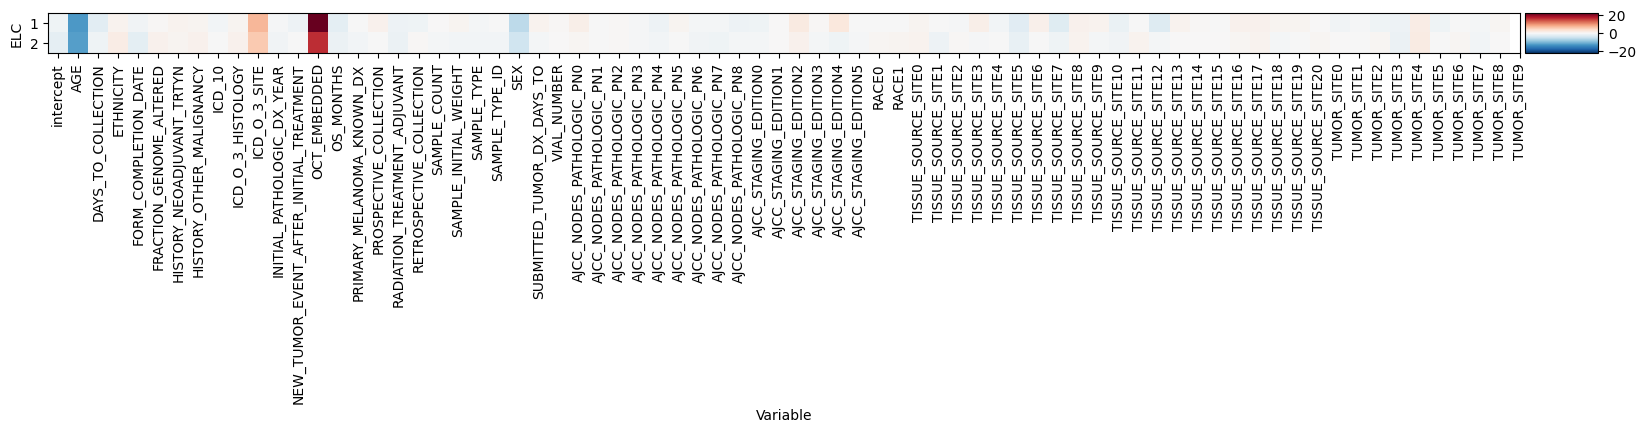

In [110]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_mosaic(MODELS, epic_id=range(2), log_trans=False, ax=ax)
# plt.savefig('SKCM_heatmap.pdf')

In [111]:
f, axs = plt.subplots(4, 1, figsize=(10,30), dpi=600)
# f.tight_layout()
plt.subplots_adjust(hspace=0.4)
for i in range(10):
    j = (0, 1, 3, 4, 7, 9, 10, 13, 19, 23)[i]
    ax = plt.subplot(10, 1,i+1)
    plot_ci(MODELS,j,epic_id=range(2),ax=ax,title=True)

# LIME

In [112]:
from lime import lime_tabular
from interpret import show
import time

Elapsed time to compute the importances: 0.006 seconds


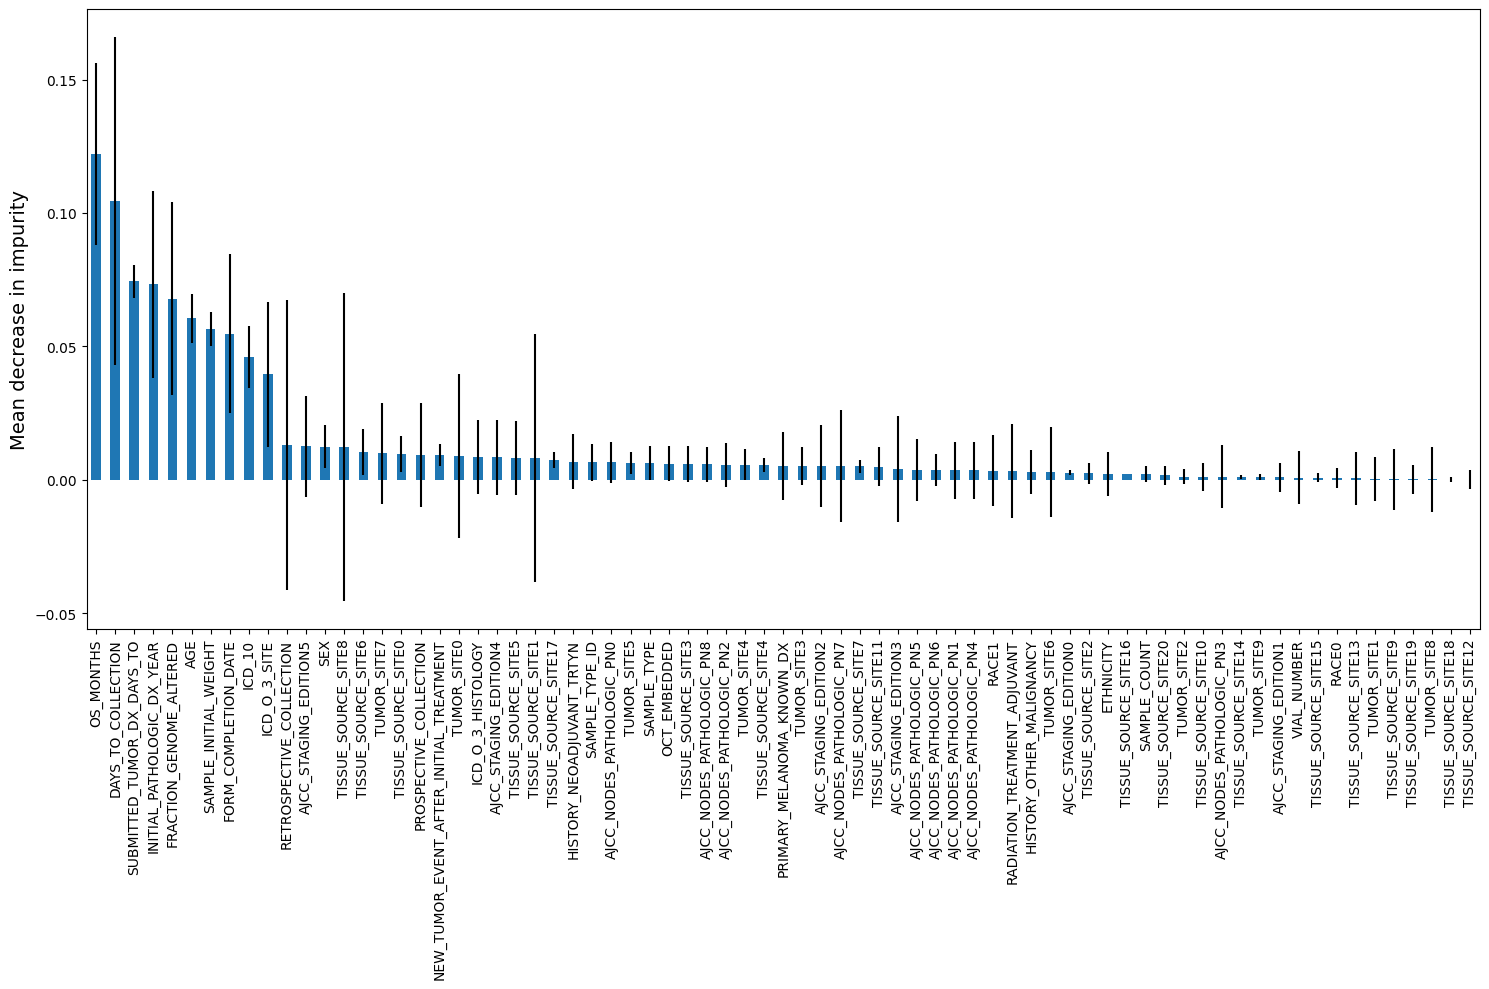

In [113]:
start_time = time.time()
importances = clf_1.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_1.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15, 10))
forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", fontsize=14)
fig.tight_layout()
# fig.savefig(f'./Plots_SKCM/Feature_importance.png', dpi=fig.dpi)

In [114]:
important_10 = np.array(forest_importances[:10].index)

In [115]:
k = 0
ids_imp10 = []
res_models = {}
for f in important_10:
    res_models[f] = {}

def log(x): return np.sign(x)*np.log(np.abs(x)+1)
# def log(x): return x

for i in feature_names:
    if i in important_10:
        print(k, i)
        print('model 1', log(MODELS[0].params[k]), log(MODELS[0].conf_int()[k]))
        print('model 2', log(MODELS[1].params[k]), log(MODELS[1].conf_int()[k]))
        res_models[i]['coef_m1'] = log(MODELS[0].params[k])
        res_models[i]['coef_m2'] = log(MODELS[1].params[k])
        res_models[i]['ci_m1'] = log(MODELS[0].conf_int()[k])
        res_models[i]['ci_m2'] = log(MODELS[1].conf_int()[k])
        ids_imp10.append(k)
    k += 1

0 AGE
model 1 -0.6973358365052444 [-1.08337871 -0.06028966]
model 2 -1.1086979402609942 [-1.25258516 -0.94057052]
1 DAYS_TO_COLLECTION
model 1 -2.6204586599799407 [-2.73370397 -2.49273139]
model 2 -2.5813090539195205 [-2.63785108 -2.52137742]
3 FORM_COMPLETION_DATE
model 1 0.5466849166155308 [-0.18467668  0.97752233]
model 2 0.9655766919338648 [0.81154119 1.09902169]
4 FRACTION_GENOME_ALTERED
model 1 -0.5992355746199607 [-1.03039611  0.14904279]
model 2 -1.1424642896181436 [-1.27286278 -0.9924756 ]
7 ICD_10
model 1 0.46554026068891324 [-0.45017105  1.01317404]
model 2 0.6335565881166781 [0.31908965 0.87243332]
9 ICD_O_3_SITE
model 1 0.446522834348822 [-0.47577615  1.00613125]
model 2 0.6684096257392255 [0.36121362 0.90308133]
10 INITIAL_PATHOLOGIC_DX_YEAR
model 1 2.1367152513728955 [1.96211878 2.28531124]
model 2 1.9286717345206241 [1.8358031  2.01364393]
13 OS_MONTHS
model 1 3.146001210343113 [3.05110808 3.23266491]
model 2 2.855852891299759 [2.80463354 2.90457615]
19 SAMPLE_INITIAL_W

In [116]:
def predict_logistic(features, coefficients, intercept=0):
    """
    Predicts probabilities for logistic regression based on features, coefficients, and an optional intercept.

    Parameters:
    features (array-like): A 2D array where each row is a data point and each column is a feature.
    coefficients (array-like): A 1D array of coefficients corresponding to the features.
    intercept (float, optional): The intercept term. Default is 0.

    Returns:
    numpy.ndarray: An array of predicted probabilities.
    """
    # Convert inputs to numpy arrays for matrix operations
    features = np.array(features)
    coefficients = np.array(coefficients)

    # Calculate the linear combination (z)
    linear_combination = np.dot(features, coefficients) + intercept

    # Apply the sigmoid function to get probabilities
    probabilities = 1 / (1 + np.exp(-linear_combination))

    return probabilities

In [117]:
from sklearn.linear_model import Lasso
from lime.lime_tabular import LimeTabularExplainer
from joblib import Parallel, delayed

# Create LIME tabular explainer
explainer = LimeTabularExplainer(
    X_test,
    feature_names=feature_names,
    class_names=df["OS_STATUS"].unique(),
    mode='classification'
)

# Function to generate explanation for a single instance
def explain_instance(index):
#     print(f"\033[1m\nStep: {index}\033[0m")
    instance = X_test[index]

    # Generate explanation using Lasso
    exp = explainer.explain_instance(instance, clf_1.predict_proba, num_features=73, model_regressor=Lasso(alpha=0.001))
    coefs_tuples = sorted(exp.as_map()[1], key=lambda x: x[0])
    coefs = [item[1] for item in coefs_tuples]

    predictions_lime = int(np.round(predict_logistic(instance, coefs, intercept=exp.intercept[1])))
    return exp.as_list(), predictions_lime

# Parallelize using joblib
lime_data = Parallel(n_jobs=1)(delayed(explain_instance)(i) for i in range(len(X_test)))

# Flatten the results if needed
lime_data = [item[0] for item in lime_data]
predictions_lime = [item[1] for item in lime_data]


In [118]:
flattened_list = [item for sublist in lime_data for item in sublist if item]
lime_data = flattened_list

In [119]:
import re

result = {}

def extract_feature(condition):
    match = re.search(r'[A-Za-z_]+[A-Za-z0-9_]*', condition)
    if match:
        return match.group(0)
    return None

# Iterate over the tuples
for condition, value in lime_data:
    feature = extract_feature(condition)
    
    if feature:
        if feature in result:
            result[feature].append(value)
        else:
            result[feature] = [value]

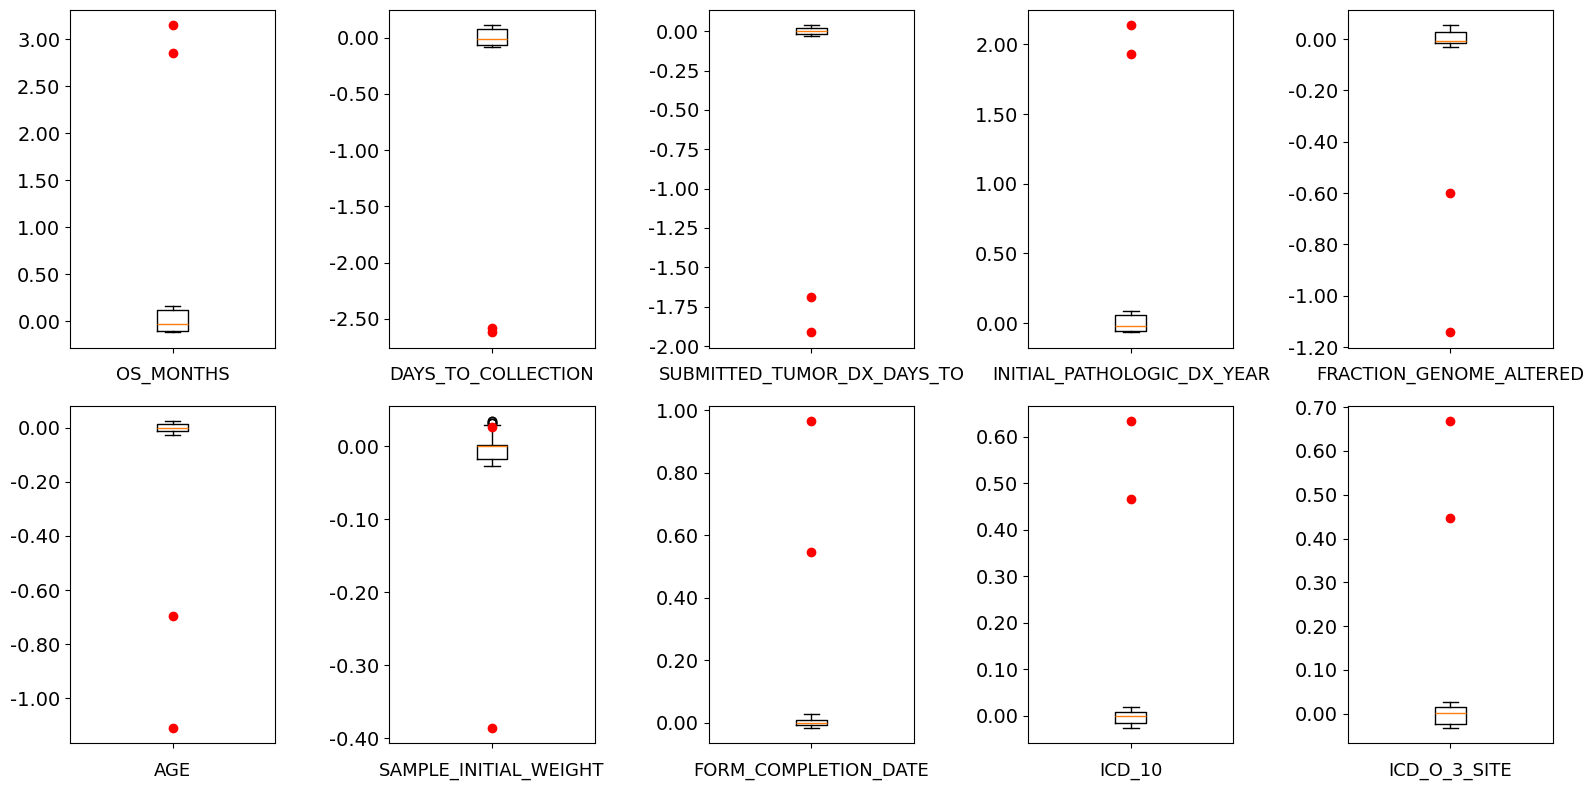

In [120]:
import statistics
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

stats_result = {}

n_features = len(important_10)
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 8))
axs = axs.flatten()

for idx, feature in enumerate(important_10):
    values = result[feature]

    axs[idx].boxplot(log(values))
#     axs[idx].boxplot(res_models_mlm[f'{feature}'])

    point1 = res_models[f'{feature}']['coef_m1']
    point2 = res_models[f'{feature}']['coef_m2']
    
    ci1 = res_models[f'{feature}']['ci_m1']
    ci2 = res_models[f'{feature}']['ci_m2']

    axs[idx].scatter([1, 1], [point1, point2], color='red', zorder=5, label='Coef Points')

    axs[idx].set_xticks([1])
    axs[idx].set_xticklabels([feature], fontsize=13)
    axs[idx].tick_params(axis='x', pad=10)


    yticks = axs[idx].get_yticks()
    yticks = yticks[1:-1]
    axs[idx].set_yticks(yticks)
    axs[idx].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    axs[idx].set_yticklabels([f'{tick:.2f}' for tick in yticks], fontsize=14)
    
plt.tight_layout()
plt.show()
# fig.savefig(f'./Plots_SKCM/ALL-Boxplots-ST-MLM.png', dpi=fig.dpi)

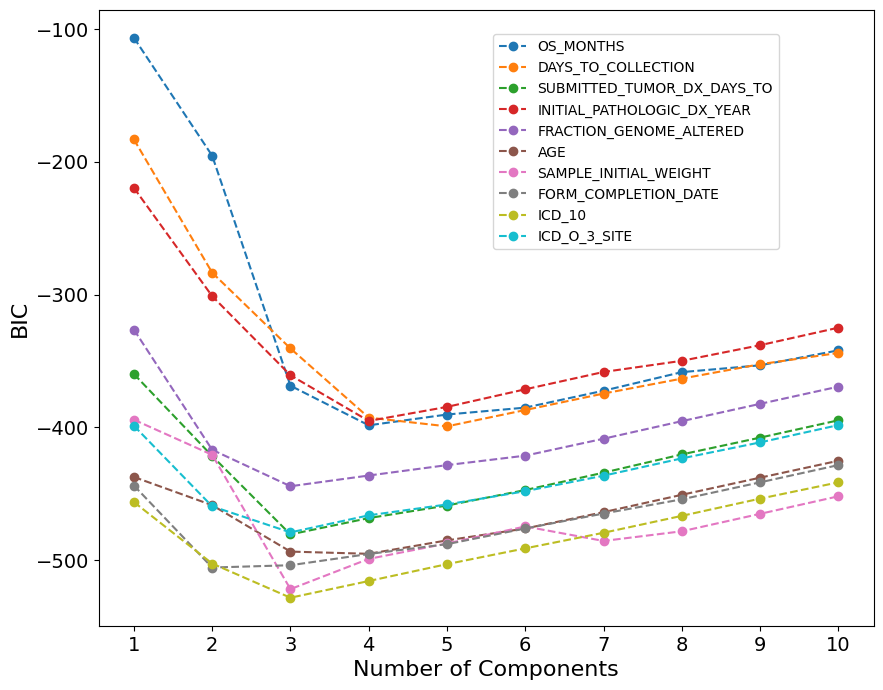

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def compute_bic(X, max_clusters=10):
    n_components = np.arange(1, max_clusters + 1)
    bics = []

    for n in n_components:
        gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
        gmm.fit(X)
        bics.append(gmm.bic(X))
    
    return n_components, bics

fig = plt.figure(figsize=(10, 8))
for feature in important_10:

    data = np.array(result[f'{feature}'])

    X = data.reshape(-1, 1)

    n_components, bics = compute_bic(X)

    plt.plot(n_components, bics, marker='o', linestyle='--', label=f'{feature}')
    plt.legend(bbox_to_anchor=(0.5, 0.6))
    plt.xlabel('Number of Components', fontsize=16)
    plt.ylabel('BIC', fontsize=16)
    plt.xticks(n_components, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    
plt.show()
# fig.savefig(f'./Plots_SKCM/ALL-BIC-sep-new.png', dpi=fig.dpi)

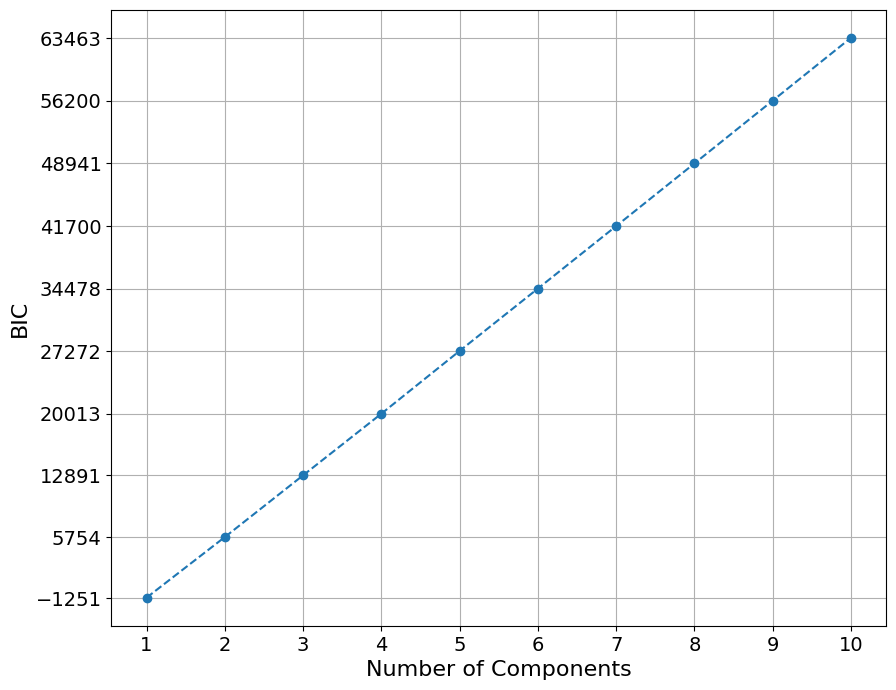

In [122]:
coefs_data = []

for feature in important_10:

    coefs_data.append(np.array(result[f'{feature}']))

n_components, bics = compute_bic(np.array(coefs_data))

fig = plt.figure(figsize=(10, 8))
plt.plot(n_components, bics, marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=16)
plt.ylabel('BIC', fontsize=16)
plt.xticks(n_components, fontsize=14)
plt.yticks(bics, fontsize=14)
plt.grid()
plt.show()
# fig.savefig(f'./Plots_SKCM/BIC-All-new.png', dpi=fig.dpi)


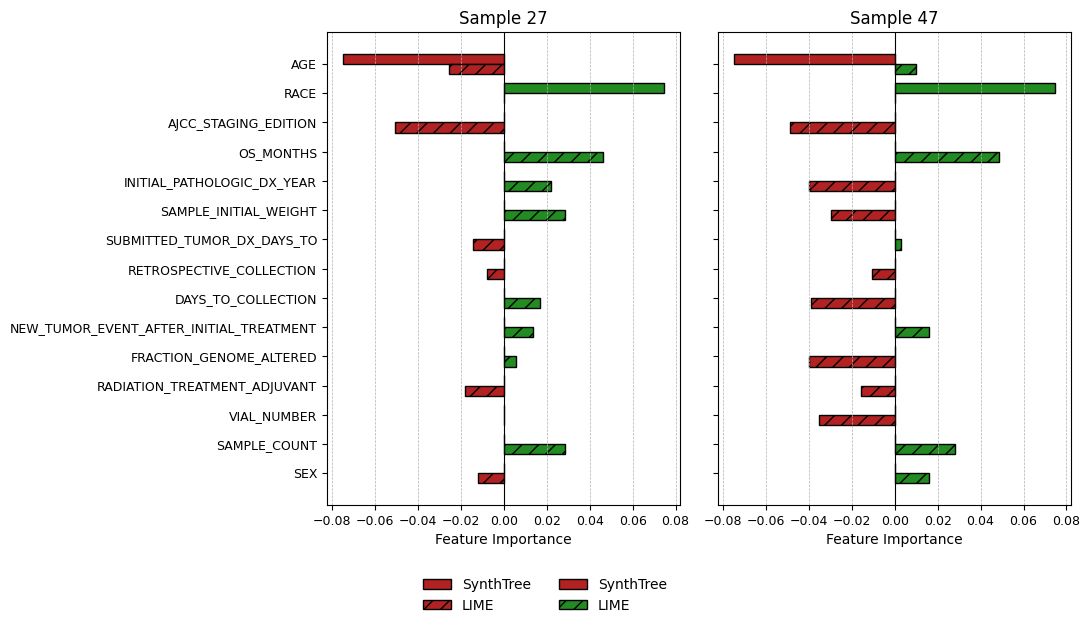

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# === Top features (union of both LIME explanations and SynthTree) ===
features = [
    'AGE', 'RACE', 'AJCC_STAGING_EDITION', 'OS_MONTHS',
    'INITIAL_PATHOLOGIC_DX_YEAR', 'SAMPLE_INITIAL_WEIGHT',
    'SUBMITTED_TUMOR_DX_DAYS_TO', 'RETROSPECTIVE_COLLECTION',
    'DAYS_TO_COLLECTION', 'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT',
    'FRACTION_GENOME_ALTERED', 'RADIATION_TREATMENT_ADJUVANT',
    'VIAL_NUMBER', 'SAMPLE_COUNT', 'SEX'
]

# === SynthTree coefficients (same for both samples) ===
synth_values = {
    'AGE': -0.0749,
    'RACE': 0.0747
    # All other features implicitly have 0 weight
}

# === LIME weights for sample 27 ===
lime_27 = {
  'AJCC_STAGING_EDITION': -0.0508,
  'OS_MONTHS': 0.0461,
  'SAMPLE_COUNT': 0.0284,
  'SAMPLE_INITIAL_WEIGHT': 0.0283,
  'AGE': -0.0254,
  'INITIAL_PATHOLOGIC_DX_YEAR': 0.0221,
  'RADIATION_TREATMENT_ADJUVANT': -0.0181,
  'DAYS_TO_COLLECTION': 0.0167,
  'HISTORY_OTHER_MALIGNANCY': 0.0166,
  'ICD_10': 0.0160,
  'SUBMITTED_TUMOR_DX_DAYS_TO': -0.0143,
  'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT': 0.0135,
  'SEX': -0.0121,
  'ICD_O_3_SITE': 0.0088,
  'SAMPLE_TYPE': -0.0084,
  'RETROSPECTIVE_COLLECTION': -0.0076,
  'FORM_COMPLETION_DATE': -0.0067,
  'TISSUE_SOURCE_SITE': -0.0057,
  'FRACTION_GENOME_ALTERED': 0.0056,
  'PROSPECTIVE_COLLECTION': 0.0039,
  'ICD_O_3_HISTOLOGY': 0.0032,
  'AJCC_NODES_PATHOLOGIC_PN': -0.0007,
  'TUMOR_SITE': -0.0007,
  'HISTORY_NEOADJUVANT_TRTYN': 0.0001,
    
}

# === LIME weights for sample 47 ===
lime_47 = {
  'OS_MONTHS': 0.0488,
  'AJCC_STAGING_EDITION': -0.0487,
  'FRACTION_GENOME_ALTERED': -0.0401,
  'INITIAL_PATHOLOGIC_DX_YEAR': -0.0398,
  'DAYS_TO_COLLECTION': -0.0388,
  'VIAL_NUMBER': -0.0351,
  'SAMPLE_INITIAL_WEIGHT': -0.0295,
  'SAMPLE_COUNT': 0.0279,
  'SEX': 0.0159,
  'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT': 0.0158,
  'RADIATION_TREATMENT_ADJUVANT': -0.0155,
  'HISTORY_OTHER_MALIGNANCY': 0.0128,
  'RETROSPECTIVE_COLLECTION': -0.0106,
  'AGE': 0.0100,
  'TUMOR_SITE': -0.0059,
  'ICD_O_3_SITE': -0.0044,
  'PROSPECTIVE_COLLECTION': -0.0038,
  'SUBMITTED_TUMOR_DX_DAYS_TO': 0.0031,
  'ICD_10': 0.0030,
  'FORM_COMPLETION_DATE': -0.0029,
  'HISTORY_NEOADJUVANT_TRTYN': -0.0012,
  'TISSUE_SOURCE_SITE': 0.0012,
  'ICD_O_3_HISTOLOGY': 0.0010,
  'SAMPLE_TYPE': -0.0002,
  'AJCC_NODES_PATHOLOGIC_PN': -0.0001,
}

# === Helper: Convert dict to ordered values based on feature list ===
def aligned_values(base_dict):
    return [base_dict.get(feat, 0.0) for feat in features]

synth_vals = aligned_values(synth_values)
lime_vals_27 = aligned_values(lime_27)
lime_vals_47 = aligned_values(lime_47)

# === Plotting ===
x = np.arange(len(features))
width = 0.35

fig, axs = plt.subplots(1, 2, figsize=(11, 6), sharey=True)

# Color helper
def get_colors(values):
    return ['forestgreen' if v > 0 else 'firebrick' if v < 0 else 'lightgray' for v in values]

# Sample 27
axs[0].barh(x - width/2, synth_vals, height=width, label='SynthTree',
            color=get_colors(synth_vals), edgecolor='black')
axs[0].barh(x + width/2, lime_vals_27, height=width, label='LIME',
            color=get_colors(lime_vals_27), edgecolor='black', hatch='//')
axs[0].set_title('Sample 27')
axs[0].set_yticks(x)
axs[0].set_yticklabels(features)
axs[0].invert_yaxis()
axs[0].set_xlabel('Feature Importance')

# Sample 47
axs[1].barh(x - width/2, synth_vals, height=width, label='SynthTree',
            color=get_colors(synth_vals), edgecolor='black')
axs[1].barh(x + width/2, lime_vals_47, height=width, label='LIME',
            color=get_colors(lime_vals_47), edgecolor='black', hatch='//')
axs[1].set_title('Sample 47')
axs[1].set_xlabel('Feature Importance')

# Shared formatting
for ax in axs:
    ax.axvline(0, color='black', linewidth=0.8)
    ax.grid(axis='x', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=9)

# Legend and layout
fig.legend(loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.05))
fig.tight_layout()
plt.subplots_adjust(bottom=0.15)

# Save files
# fig.savefig("same_leaf_explanation_colored.pdf", bbox_inches="tight")
# fig.savefig("same_leaf_explanation_colored.png", dpi=300, bbox_inches="tight")
plt.show()

[info] Using tree-stored matrix: (10310, 73) | names aligned: True

=== Sample 0 ===
Path through SynthTree:
  Feature 39 <= 0.004065
SynthTree top features:
  Feature 13                     +22.2429
  Feature 1                      -12.7420
  Feature 10                     +7.4716
  Feature 23                     -5.7715
  Feature 55                     -2.9177
  Feature 50                     -2.6877
  Feature 48                     -2.4527
  Feature 39                     +2.4087
  Feature 2                      -2.3122
  Feature 14                     -2.1835
LIME top features:
  Feature 17 <= 0.01             -0.1006
  7.97 < Feature 13 ≤ 8.50       -0.0795
  4.17 < Feature 1 ≤ 4.65        +0.0776
  Feature 48 > 0.10              +0.0649
  Feature 33 > 0.12              +0.0579
  106.89 < Feature 10 ≤ 116.48   +0.0555
  Feature 0 <= 0.43              -0.0528
  Feature 4 <= 0.21              -0.0492
  Feature 38 > 0.88              +0.0449
  Feature 67 > 0.09              +0.0410


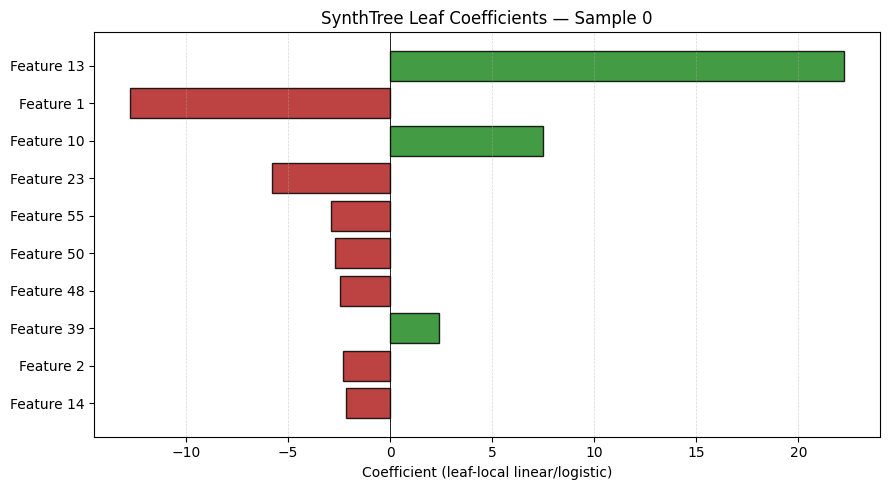

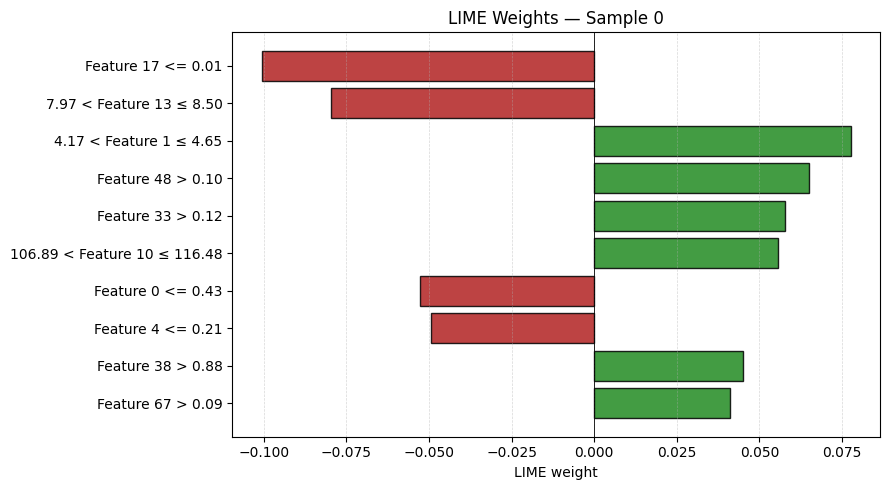


=== Sample 1 ===
Path through SynthTree:
  Feature 39 <= 0.004065
SynthTree top features:
  Feature 13                     +22.2429
  Feature 1                      -12.7420
  Feature 10                     +7.4716
  Feature 23                     -5.7715
  Feature 55                     -2.9177
  Feature 50                     -2.6877
  Feature 48                     -2.4527
  Feature 39                     +2.4087
  Feature 2                      -2.3122
  Feature 14                     -2.1835
LIME top features:
  7.54 < Feature 13 ≤ 7.97       +0.1806
  3.80 < Feature 1 ≤ 4.17        -0.1122
  Feature 48 > 0.10              +0.0857
  Feature 17 <= 0.01             -0.0830
  Feature 39 <= 0.00             -0.0438
  45.63 < Feature 4 ≤ 49.57      -0.0385
  8.59 < Feature 14 ≤ 8.82       +0.0327
  449.24 < Feature 11 ≤ 472.45   +0.0315
  66.98 < Feature 0 ≤ 69.36      +0.0294
  0.97 < Feature 21 <= 1.05      +0.0293


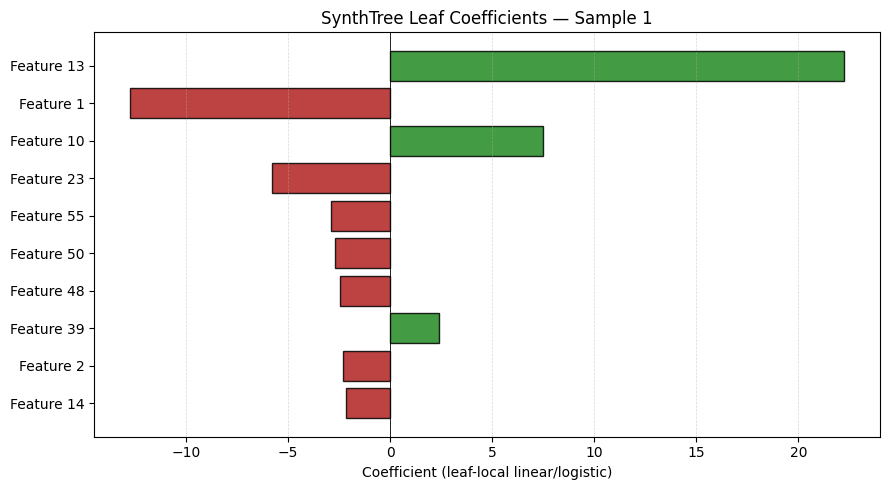

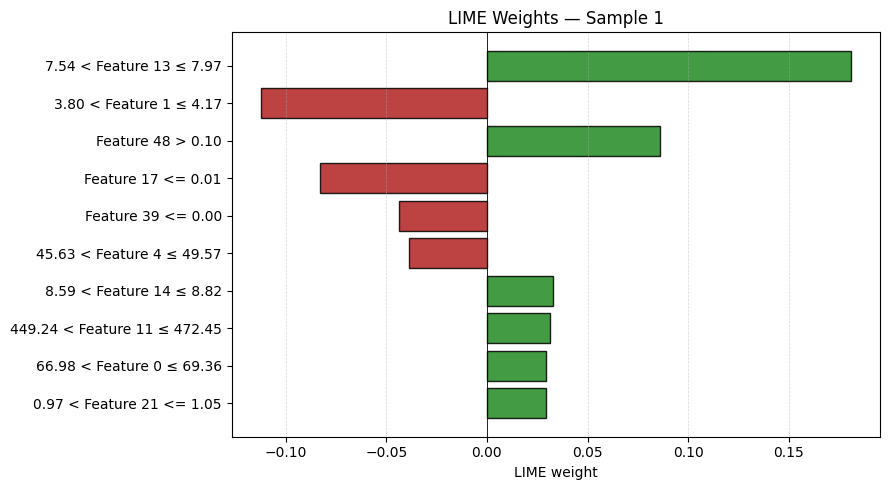

In [172]:
# =========================================================
# SynthTree (best_object_tree) vs LIME — TWO SEPARATE PLOTS per sample
# =========================================================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# -----------------------------
# CONFIG
# -----------------------------
sample_indices = [0, 1]   # indices within the tree's stored training matrix
top_k_to_show = 10             # how many features to show in each plot

# =========================================================
# 0) Load & preprocess (only to recover continuous means/stds for denormalization)
# =========================================================
df = pd.read_csv("./data/TCGA_skcm.csv")
data = df.iloc[:, 1:]
outcome_col = "OS_STATUS"

feature_names_raw = [c for c in data.columns if c != outcome_col and len(np.unique(data[c])) > 1]
Xo = data[feature_names_raw].values

dfX = pd.DataFrame(Xo, columns=feature_names_raw)
categorical = [col for col in dfX.columns if dfX[col].dtype == object or len(np.unique(dfX[col])) < 5]
continuous = [col for col in dfX.columns if col not in categorical]

X_cont = dfX[continuous].astype(float)
means = X_cont.mean().values
stds  = X_cont.std().values + 1e-8
X_cont_z = (X_cont - means) / stds

X_cat = pd.get_dummies(dfX[categorical], drop_first=False)
X_df_pre = pd.concat([X_cont_z, X_cat], axis=1)
feature_names_pre = list(X_df_pre.columns)

means_dict = dict(zip(continuous, means))
stds_dict  = dict(zip(continuous, stds))
n_cont = len(continuous)

# =========================================================
# 1) Get your fitted SynthTree object (alias either variable name)
# =========================================================
try:
    best_tree = best_tree_object
except NameError:
    raise RuntimeError("Put your fitted tree into variable 'best_object_tree' or 'best_tree_object'.")

# =========================================================
# 2) Use the EXACT matrix the tree fit on (stored at root['X'])
# =========================================================
def _root_training_X(tree_obj):
    X_root = tree_obj.tree.get('X', None)
    if X_root is None:
        raise ValueError("Tree root has no 'X'. Fit the leaf models on this instance first.")
    return np.asarray(X_root)

X_tree_used = _root_training_X(best_tree)  # (n, p)
p_features  = X_tree_used.shape[1]

# Prefer your real preprocessed names if shape matches; else fall back to "Feature i"
feat_names = feature_names_pre[:] if len(feature_names_pre) == p_features else [f"Feature {i}" for i in range(p_features)]
X_tree_df = pd.DataFrame(X_tree_used, columns=feat_names)
print(f"[info] Using tree-stored matrix: {X_tree_df.shape} | names aligned: {len(feat_names)==p_features}")

# =========================================================
# 3) Tree routing & leaf-model helpers
# =========================================================
def _guarded_get_leaf_node(tree_obj, x_row_1d):
    node = tree_obj.tree
    nF = x_row_1d.shape[0]
    while 'leaf' not in node:
        fi  = node['feature_index']    # 0-based
        thr = node['threshold']
        if fi >= nF:
            raise IndexError(f"Row has {nF} features but split asks for index {fi}. "
                             "Use the exact matrix the tree was fit on.")
        node = node['left'] if x_row_1d[fi] <= thr else node['right']
    return node

def _get_leaf_model(tree_obj, x_row_1d):
    leaf = _guarded_get_leaf_node(tree_obj, x_row_1d)
    return leaf.get('model', None), leaf

def _need_const_for_statsmodels(mdl, p):
    model = getattr(mdl, "model", None)
    k_exog = getattr(model, "k_exog", None) if model is not None else getattr(mdl, "k_exog", None)
    exog_names = getattr(model, "exog_names", None) if model is not None else getattr(mdl, "exog_names", None)
    need_const = False
    if k_exog is not None:
        need_const = (k_exog == p + 1)
    if exog_names and len(exog_names) == p + 1 and str(exog_names[0]).lower() in ("const","intercept"):
        need_const = True
    return need_const

def _prepare_exog_for_statsmodels(mdl, X2d):
    X2d = np.asarray(X2d)
    if _need_const_for_statsmodels(mdl, X2d.shape[1]):
        ones = np.ones((X2d.shape[0], 1))
        return np.concatenate([ones, X2d], axis=1)
    return X2d

def _coef_from_model(local_model, n_features):
    # sklearn linear/logistic
    if hasattr(local_model, "coef_"):
        coef = np.asarray(local_model.coef_)
        vec = coef if coef.ndim == 1 else coef[0]
        if vec.size < n_features:
            full = np.zeros(n_features); full[:vec.size] = vec; vec = full
        elif vec.size > n_features:
            vec = vec[:n_features]
        return vec
    # statsmodels OLS/Logit results
    if hasattr(local_model, "params"):
        params = np.asarray(local_model.params)
        exog_names = getattr(getattr(local_model, "model", local_model), "exog_names", None)
        if exog_names and len(exog_names) == params.size and str(exog_names[0]).lower() in ("const","intercept"):
            params = params[1:]
        elif params.size == n_features + 1:
            params = params[1:]
        elif params.size > n_features:
            params = params[:n_features]
        if params.size < n_features:
            params = np.pad(params, (0, n_features - params.size))
        return params
    raise AttributeError("Unrecognized leaf model type (expected sklearn coef_ or statsmodels params).")

# Always show path labels as zero-based "Feature i" to match your “True tree”
def _split_label(fi): return f"Feature {fi}"

def get_leaf_model_and_path_for_tree(tree_obj, x_row):
    node = tree_obj.tree
    path = []
    while 'leaf' not in node:
        fi  = node['feature_index']   # 0-based
        thr = node['threshold']
        lab = _split_label(fi)
        if x_row[fi] <= thr:
            path.append(f"{lab} <= {thr:.6f}")
            node = node['left']
        else:
            path.append(f"{lab} > {thr:.6f}")
            node = node['right']
    return node.get('model', None), path

# =========================================================
# 4) LIME wrapper over the tree
# =========================================================
def tree_predict_proba(tree_obj, X_np):
    def _sigmoid(z): return 1.0 / (1.0 + np.exp(-z))
    X_np = np.asarray(X_np)
    out = []
    for x in X_np:
        mdl, _ = _get_leaf_model(tree_obj, x)
        if mdl is None:
            p1 = 0.5
        else:
            if hasattr(mdl, "predict_proba"):
                p1 = float(mdl.predict_proba(x.reshape(1,-1))[0,1])
            elif hasattr(mdl, "predict"):
                exog = _prepare_exog_for_statsmodels(mdl, x.reshape(1,-1))
                val = mdl.predict(exog)
                p1 = float(val[0]) if np.ndim(val) else float(val)
                if not (0.0 <= p1 <= 1.0):
                    p1 = float(_sigmoid(p1))
            else:
                w = _coef_from_model(mdl, n_features=x.shape[0])
                p1 = float(_sigmoid(np.dot(w, x)))
        out.append([1.0 - p1, p1])
    return np.array(out)

explainer = LimeTabularExplainer(
    training_data=X_tree_df.values,
    feature_names=feat_names,
    class_names=["class 0", "class 1"],
    mode="classification",
    discretize_continuous=True
)

# =========================================================
# 5) Denormalization helpers (support both real names and "Feature i")
# =========================================================
def _idx_from_label(label):
    m = re.fullmatch(r"Feature\s+(\d+)", str(label))
    return int(m.group(1)) if m else None

def denormalize_condition(cond_str, means_dict, stds_dict):
    # Expect "Feature i <= thr" or "NAME <= thr"
    try:
        parts = cond_str.split()
        if len(parts) != 3:
            return cond_str
        label, op, thr_s = parts
        thr = float(thr_s)
        idx = _idx_from_label(label)
        if idx is not None and idx < n_cont:
            t_orig = thr * stds[idx] + means[idx]
            return f"{label} {op} {t_orig:.2f}"
        if label in means_dict:
            t_orig = thr * stds_dict[label] + means_dict[label]
            return f"{label} {op} {t_orig:.2f}"
        return cond_str
    except Exception:
        return cond_str

def denormalize_lime_condition(name, means_dict, stds_dict):
    try:
        if '<=' in name and '<' in name:  # "a < Label <= b"
            left, rest = name.split('<', 1)
            left = left.strip()
            lab, right = rest.split('<=')
            lab = lab.strip(); right = right.strip()
            lower = float(left); upper = float(right)
            idx = _idx_from_label(lab)
            if idx is not None and idx < n_cont:
                l_orig = lower * stds[idx] + means[idx]
                u_orig = upper * stds[idx] + means[idx]
                return f"{l_orig:.2f} < {lab} ≤ {u_orig:.2f}"
            if lab in means_dict:
                l_orig = lower * stds_dict[lab] + means_dict[lab]
                u_orig = upper * stds_dict[lab] + means_dict[lab]
                return f"{l_orig:.2f} < {lab} ≤ {u_orig:.2f}"
            return name

        for op in ['<=','>=','<','>']:     # "Label <= t"
            if op in name:
                lab, thr_s = name.split(op)
                lab = lab.strip(); thr = float(thr_s.strip())
                idx = _idx_from_label(lab)
                if idx is not None and idx < n_cont:
                    t_orig = thr * stds[idx] + means[idx]
                    return f"{lab} {op} {t_orig:.2f}"
                if lab in means_dict:
                    t_orig = thr * stds_dict[lab] + means_dict[lab]
                    return f"{lab} {op} {t_orig:.2f}"
                return name
        return name
    except Exception:
        return name

# =========================================================
# 6) Single-figure bar plot helper
# =========================================================
def plot_single_barh(weights_dict, title, xlabel, top_k=20):
    feats = sorted(weights_dict, key=lambda f: abs(weights_dict[f]), reverse=True)[:top_k]
    vals  = [weights_dict[f] for f in feats]
    y = np.arange(len(feats))

    fig, ax = plt.subplots(figsize=(9, max(4, 0.5*len(feats))))
    colors = ["forestgreen" if v > 0 else "firebrick" for v in vals]
    ax.barh(y, vals, color=colors, edgecolor="black", alpha=0.85)
    ax.set_yticks(y); ax.set_yticklabels(feats)
    ax.axvline(0, color="black", lw=0.6)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(axis="x", linestyle="--", lw=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()

# =========================================================
# 7) Run for your samples (indices in X_tree_df) — TWO FIGURES per sample
# =========================================================
for idx in sample_indices:
    x_row = X_tree_df.iloc[idx].values

    # Path & leaf model (labels like "Feature 39" to match your printouts)
    leaf_model, path = get_leaf_model_and_path_for_tree(best_tree, x_row)
    denorm_path = [denormalize_condition(s, means_dict, stds_dict) for s in path]

    print(f"\n=== Sample {idx} ===")
    print("Path through SynthTree:")
    print("  " + " → ".join(denorm_path) if denorm_path else "  (root is leaf)")

    # SynthTree weights (leaf local linear/logistic model)
    synth_weights = {}
    if leaf_model is not None:
        w = _coef_from_model(leaf_model, n_features=p_features)
        synth_weights = dict(zip(feat_names, w))
        # quick text preview
        top_print = dict(sorted(synth_weights.items(), key=lambda kv: abs(kv[1]), reverse=True)[:10])
        print("SynthTree top features:")
        for feat, weight in top_print.items():
            print(f"  {feat:30s} {weight:+.4f}")
    else:
        print("Leaf has no model; using zeros.")

    # LIME explanation for this row
    probs = tree_predict_proba(best_tree, x_row.reshape(1,-1))[0]
    pred_class = int(np.argmax(probs))
    exp = explainer.explain_instance(
        data_row=x_row,
        predict_fn=lambda A: tree_predict_proba(best_tree, A),
        num_features=p_features,
        labels=[pred_class]
    )
    lime_pairs = exp.as_list(label=pred_class)
    lime_weights = dict(lime_pairs)

    print("LIME top features:")
    for name, weight in lime_pairs[:10]:
        readable = denormalize_lime_condition(name, means_dict, stds_dict)
        print(f"  {readable:30s} {weight:+.4f}")

    # Denormalize labels (works for real names or "Feature i")
    synth_den = {denormalize_lime_condition(k, means_dict, stds_dict): v for k, v in synth_weights.items()}
    lime_den  = {denormalize_lime_condition(k, means_dict, stds_dict): v for k, v in lime_weights.items()}

    # === Two separate figures ===
    plot_single_barh(
        synth_den,
        title=f"SynthTree Leaf Coefficients — Sample {idx}",
        xlabel="Coefficient (leaf-local linear/logistic)",
        top_k=top_k_to_show
    )

    plot_single_barh(
        lime_den,
        title=f"LIME Weights — Sample {idx}",
        xlabel="LIME weight",
        top_k=top_k_to_show
    )